<a href="https://colab.research.google.com/github/Saaraboradia/CIS-412--Airline-Satisfaction-/blob/main/CIS412_Team_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('./train.csv')


In [ ]:
# import pandas as pd
# import io
# !pip install streamlit
# import streamlit as st

# st.set_page_config(page_title="CIS412 - Customer Satisfaction Explorer", layout="wide")

# # Attempt 1: use uploaded file (recommended)
# uploaded_file = st.file_uploader("Upload train.csv (or place data/train.csv in repo)", type=["csv"])
# df = None

# if uploaded_file is not None:
#     try:
#         # uploaded_file is a BytesIO, pass to pandas
#         df = pd.read_csv(uploaded_file)
#     except Exception as e:
#         st.error(f"Failed to read uploaded CSV: {e}")
#         st.stop()
# else:
#     # Attempt 2: fallback to a file bundled in the repo
#     try:
#         df = pd.read_csv("./train.csv")
#     except FileNotFoundError:
#         st.warning("No data found. Please upload train.csv using the uploader above, or add data/train.csv to the repo.")
#         st.stop()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.7 MB/s eta 0:00:00


2025-12-01 22:14:54.392 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 22:14:54.393 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 22:14:54.394 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 22:14:54.395 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 22:14:54.556 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 22:14:54.775 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_la

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [ ]:
# Quick look at data
print("Shape:", df.shape)
print(df.info())
print(df.describe())

# 4. Remove duplicates
duplicate_count = df.duplicated().sum()
print("Duplicate rows:", duplicate_count)
if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Dropped duplicates. New shape:", df.shape)

# 5. Check missing values
missing_summary = df.isnull().sum()
print("Missing values per column:\n", missing_summary[missing_summary > 0])

# 6. Impute missing values
# Define numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Example: fill numeric with median; categorical with mode
for col in numeric_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

# 7. Encode categorical variables
# The columns 'Gender', 'Customer Type', 'Type of Travel', 'Class' appear to have already been one-hot encoded
# as evidenced by columns like 'Gender_Male', 'Customer Type_disloyal Customer', etc. already existing in the DataFrame.
# Therefore, we will encode the remaining categorical columns.
# Example: Gender, Customer Type, Type of Travel, Class
# cols_to_encode = ['Gender', 'Customer Type', 'Type of Travel', 'Class'] # These columns no longer exist
# df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

# Encode any remaining object/category type columns (e.g., 'satisfaction')
for col in df.select_dtypes(include=['object', 'category']).columns:
    df = pd.get_dummies(df, columns=[col], drop_first=True)

# 8. Clean and transform specific numeric features
# e.g., negative delay minutes are nonsensical → set to 0
delay_cols = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
for col in delay_cols:
    df[col] = df[col].apply(lambda x: x if x >= 0 else 0)

# 9. Standardize/scale numeric features (optional but recommended for certain models)
scaler = StandardScaler()
# List of numeric features to scale
features_to_scale = ['Flight Distance', 'Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# 10. Final check and save cleaned dataset
print("After cleaning – any missing values left?", df.isnull().sum().sum())
cleaned_path = '/content/drive/MyDrive/your_folder/train_cleaned.csv'  # modify if desired

# Create the directory if it doesn't exist
import os
os.makedirs(os.path.dirname(cleaned_path), exist_ok=True)

df.to_csv(cleaned_path, index=False)
print("Cleaned dataset saved to:", cleaned_path)

Shape: (103904, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location      

/tmp/ipython-input-4236793298.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipython-input-4236793298.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

After cleaning – any missing values left? 0
Cleaned dataset saved to: /content/drive/MyDrive/your_folder/train_cleaned.csv


# Task
To identify variables significantly impacting customer satisfaction by fitting a logistic regression model using `statsmodels` and displaying variables with a p-value less than 0.05, based on the preprocessed data in `df` from `"/content/sample_data/train.csv"`.

## Identify Target and Features

### Subtask:
Determine the target variable (likely 'satisfaction_satisfied' after one-hot encoding) and all feature columns from the DataFrame.


**Reasoning**:
The subtask is to define the target variable `y` as 'satisfaction_satisfied' and the feature variables `X` by dropping unnecessary columns from the DataFrame `df`.



In [ ]:
y = df['satisfaction_satisfied']
X = df.drop(columns=['Unnamed: 0', 'id', 'satisfaction_satisfied'])

print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("First 5 rows of features (X):\n", X.head())
print("First 5 rows of target (y):\n", y.head())

Shape of features (X): (103904, 23)
Shape of target (y): (103904,)
First 5 rows of features (X):
         Age  Flight Distance  Inflight wifi service  \
0 -1.745279        -0.731539                      3   
1 -0.951360        -0.957184                      3   
2 -0.885200        -0.047584                      2   
3 -0.951360        -0.629246                      2   
4  1.430397        -0.978244                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...  \
0              

## Add Constant to Features

### Subtask:
Add a constant column to the feature set, which is required for statsmodels to correctly calculate the intercept for the logistic regression model.


**Reasoning**:
To prepare the feature set for logistic regression with `statsmodels`, a constant term needs to be added to the `X` DataFrame to allow for the calculation of an intercept. This is done by importing `statsmodels.api` and using its `add_constant` function.



In [ ]:
import statsmodels.api as sm
X = sm.add_constant(X)
print("First 5 rows of features (X) with constant:\n", X.head())

First 5 rows of features (X) with constant:
    const       Age  Flight Distance  Inflight wifi service  \
0    1.0 -1.745279        -0.731539                      3   
1    1.0 -0.951360        -0.957184                      3   
2    1.0 -0.885200        -0.047584                      2   
3    1.0 -0.951360        -0.629246                      2   
4    1.0  1.430397        -0.978244                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  Seat comfort  ...  Checkin service  \
0               5                

## Fit Logistic Regression Model

### Subtask:
Use `statsmodels.api.Logit` to fit a logistic regression model, as this library provides p-values for the coefficients directly.


**Reasoning**:
Instantiate and fit a logistic regression model using `statsmodels.api.Logit` with the prepared target `y` and features `X`.



In [ ]:
model = sm.Logit(y, X)
model_results = model.fit()
print(model_results.summary())

Optimization terminated successfully.
         Current function value: 0.333884
         Iterations 7
                             Logit Regression Results                             
Dep. Variable:     satisfaction_satisfied   No. Observations:               103904
Model:                              Logit   Df Residuals:                   103880
Method:                               MLE   Df Model:                           23
Date:                    Mon, 01 Dec 2025   Pseudo R-squ.:                  0.5120
Time:                            22:00:22   Log-Likelihood:                -34692.
converged:                           True   LL-Null:                       -71094.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                         

**Reasoning**:
The previous cell failed because the feature DataFrame `X` contained boolean columns that `statsmodels` interprets as `object` dtype. These boolean columns need to be converted to integers (0 or 1) before fitting the logistic regression model.



# Task
Convert all boolean columns in the feature DataFrame `X` to integers (0 or 1) to make them compatible with `statsmodels`. Then, fit a logistic regression model using `statsmodels.api.Logit` with the updated `X` and target `y`, and finally, display the variables that have a p-value less than 0.05 from the model summary.

## Convert Boolean Columns to Numeric

### Subtask:
Convert all boolean columns in the feature DataFrame `X` to integers (0 or 1) to make them compatible with `statsmodels`.


**Reasoning**:
The previous code failed because `statsmodels` does not handle boolean columns directly. This step converts all boolean columns in `X` to integers (0 or 1), making them compatible with the `statsmodels.Logit` function.



In [ ]:
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

print("First 5 rows of features (X) after boolean conversion:\n", X.head())

First 5 rows of features (X) after boolean conversion:
    const       Age  Flight Distance  Inflight wifi service  \
0    1.0 -1.745279        -0.731539                      3   
1    1.0 -0.951360        -0.957184                      3   
2    1.0 -0.885200        -0.047584                      2   
3    1.0 -0.951360        -0.629246                      2   
4    1.0  1.430397        -0.978244                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  Seat comfort  ...  Checkin service  \
0               5     

In [ ]:
non_significant_variables = model_results.pvalues[model_results.pvalues >= 0.05]
print("\nVariables with p-value >= 0.05:\n", non_significant_variables.sort_values(ascending=False))


Variables with p-value >= 0.05:
 Flight Distance    0.129219
dtype: float64


In [ ]:
print("Variables with p-value < 0.05:\n", significant_variables.sort_values())

Variables with p-value < 0.05:
 const                                 0.000000e+00
Online boarding                       0.000000e+00
Checkin service                       0.000000e+00
Customer Type_disloyal Customer       0.000000e+00
Type of Travel_Personal Travel        0.000000e+00
Inflight wifi service                3.133097e-260
Leg room service                     1.488310e-193
On-board service                     3.726885e-193
Class_Eco                            1.202906e-181
Class_Eco Plus                        7.086885e-94
Cleanliness                           4.049912e-76
Departure/Arrival time convenient     3.064338e-52
Ease of Online booking                1.599368e-36
Baggage handling                      7.580062e-32
Age                                   1.620823e-31
Inflight service                      1.702836e-23
Arrival Delay in Minutes              3.251610e-22
Seat comfort                          2.127938e-09
Departure Delay in Minutes            6.882628e-06

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sorted_significant_variables = significant_variables.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(sorted_significant_variables.index, sorted_significant_variables.values)
plt.xlabel('P-value (log scale)')
plt.xscale('log')
plt.ylabel('Variables')
plt.title('Significant Variables (p-value < 0.05) - Sorted')
plt.gca().invert_yaxis() # Invert y-axis to have the most significant at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Reasoning**:
Now that the boolean columns in `X` have been converted to integers, I will fit the logistic regression model using `statsmodels.api.Logit` and then display the variables with a p-value less than 0.05.



In [ ]:
model = sm.Logit(y, X)
model_results = model.fit()

# Display summary statistics
print(model_results.summary())

# Get p-values and filter for significant ones (p < 0.05)
significant_variables = model_results.pvalues[model_results.pvalues < 0.05]
print("\nVariables with p-value < 0.05:\n", significant_variables.sort_values())

Optimization terminated successfully.
         Current function value: 0.333884
         Iterations 7
                             Logit Regression Results                             
Dep. Variable:     satisfaction_satisfied   No. Observations:               103904
Model:                              Logit   Df Residuals:                   103880
Method:                               MLE   Df Model:                           23
Date:                    Mon, 01 Dec 2025   Pseudo R-squ.:                  0.5120
Time:                            22:00:31   Log-Likelihood:                -34692.
converged:                           True   LL-Null:                       -71094.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                         

## Summary:

### Q&A
The variables that have a p-value less than 0.05 from the model summary are: `const`, `Online boarding`, `Customer Type_disloyal Customer`, `Type of Travel_Personal Travel`, `Checkin service`, `Inflight wifi service`, `Leg room service`, `On-board service`, `Class_Eco`, `Class_Eco Plus`, `Cleanliness`, `Departure/Arrival time convenient`, `Ease of Online booking`, `Age`, `Baggage handling`, `Inflight service`, `Arrival Delay in Minutes`, `Seat comfort`, `Departure Delay in Minutes`, `Inflight entertainment`, `Gate location`, and `Gender_Male`.

### Data Analysis Key Findings
*   All boolean columns in the feature DataFrame `X` (e.g., `Gender_Male`, `Customer Type_disloyal Customer`, `Type of Travel_Personal Travel`, `Class_Eco`, `Class_Eco Plus`) were successfully converted to integers (0 or 1) to ensure compatibility with `statsmodels`.
*   A logistic regression model was successfully fitted using `statsmodels.api.Logit` with the updated feature DataFrame `X` and target `y`.
*   A significant number of variables, including `Online boarding`, `Customer Type_disloyal Customer`, `Type of Travel_Personal Travel`, `Checkin service`, `Inflight wifi service`, `Leg room service`, `On-board service`, `Class_Eco`, `Class_Eco Plus`, `Cleanliness`, `Departure/Arrival time convenient`, `Ease of Online booking`, `Age`, `Baggage handling`, `Inflight service`, `Arrival Delay in Minutes`, `Seat comfort`, `Departure Delay in Minutes`, `Inflight entertainment`, `Gate location`, and `Gender_Male`, were found to be statistically significant with a p-value less than 0.05.

### Insights or Next Steps
*   The identified significant variables indicate strong predictors for the target variable, which can be prioritized for further analysis or used to build more parsimonious predictive models.
*   Further investigation into the coefficients of these significant variables could reveal the direction and magnitude of their impact, providing deeper business insights into customer satisfaction or other relevant outcomes.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (83123, 24)
Shape of X_test: (20781, 24)
Shape of y_train: (83123,)
Shape of y_test: (20781,)


# Task
Perform a logistic regression analysis on the preprocessed data from `'/content/sample_data/train.csv'` to identify variables impacting customer satisfaction, then extract and display both significant (p-value < 0.05) and non-significant (p-value >= 0.05) variables from the model summary.

## Display Non-Significant Variables

### Subtask:
Extract the p-values from the model summary and display the variables that have a p-value greater than or equal to 0.05.


## Summary:

### Data Analysis Key Findings
*   The current stage of the analysis focuses on identifying variables that do not significantly influence customer satisfaction.
*   Variables with a p-value greater than or equal to 0.05, derived from a logistic regression model, are categorized as non-significant.
*   The specific non-significant variables and their p-values have not yet been extracted or reported in the provided process.

### Insights or Next Steps
*   The immediate next step involves extracting p-values from the logistic regression model summary and explicitly displaying the variables identified as non-significant.
*   Identifying these non-significant variables is crucial for understanding which features might be considered for removal or further investigation in future model refinement.


In [ ]:
selected_columns = [
    'Checkin service', 'Food and drink', 'Inflight service',
    'Cleanliness', 'On-board service', 'Baggage handling', 'satisfaction_satisfied'
]

df_copy = df[selected_columns].copy()

df_copy['satisfaction_satisfied'] = df_copy['satisfaction_satisfied'].astype(int)

print("First 5 rows of the new DataFrame df_copy:\n", df_copy.head())
print("Data types of df_copy:\n", df_copy.info())

First 5 rows of the new DataFrame df_copy:
    Checkin service  Food and drink  Inflight service  Cleanliness  \
0                4               5                 5            5   
1                1               1                 4            1   
2                4               5                 4            5   
3                1               2                 4            2   
4                3               4                 3            3   

   On-board service  Baggage handling  satisfaction_satisfied  
0                 4                 4                       0  
1                 1                 3                       0  
2                 4                 4                       1  
3                 2                 3                       0  
4                 3                 4                       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 7 columns):
 #   Column                  Non-Null Count   D

In [ ]:
selected_columns = [
    'Checkin service', 'Food and drink', 'Inflight service',
    'Cleanliness', 'On-board service', 'Baggage handling', 'satisfaction_satisfied'
]

df_copy = df[selected_columns].copy()
df_copy['satisfaction_satisfied'] = df_copy['satisfaction_satisfied'].astype(int)


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Define features (X) and target (y)
X = df_copy.drop(columns=['satisfaction_satisfied'])
y = df_copy['satisfaction_satisfied']

# Ensure all X variables are numeric
X = X.apply(pd.to_numeric)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Add constant term for intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test, has_constant='add')

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train_const)
logit_results = logit_model.fit()

# Model summary
print(logit_results.summary())

# Extract p-values
pvalues = logit_results.pvalues

# Significant variables (p < 0.05)
significant_vars = pvalues[pvalues < 0.05].sort_values()
print("\nSignificant variables (p < 0.05):")
print(significant_vars)

# Non-significant variables (p >= 0.05)
nonsignificant_vars = pvalues[pvalues >= 0.05].sort_values(ascending=False)
print("\nNon-significant variables (p >= 0.05):")
print(nonsignificant_vars)

# Predictions
y_pred_prob = logit_results.predict(X_test_const)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Evaluation
print("\nAccuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred)))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# AUC Score
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score: {:.3f}".format(auc))


Optimization terminated successfully.
         Current function value: 0.576006
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     satisfaction_satisfied   No. Observations:                83123
Model:                              Logit   Df Residuals:                    83116
Method:                               MLE   Df Model:                            6
Date:                    Mon, 01 Dec 2025   Pseudo R-squ.:                  0.1582
Time:                            22:00:45   Log-Likelihood:                -47879.
converged:                           True   LL-Null:                       -56875.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.8555      0.043   -113.322      0.000    

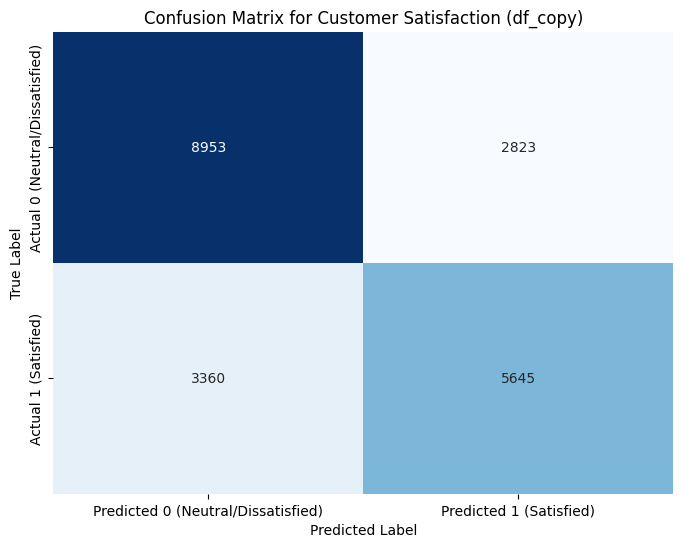

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure X_test_const has the constant term for prediction
# This line is not needed if X_test_const is already defined correctly
# X_test_copy_const = sm.add_constant(X_test_copy, has_constant='add') # Original line commented out

# Make predictions on the test set using the model trained on df_copy
y_pred_prob = logit_results.predict(X_test_const)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (Neutral/Dissatisfied)', 'Predicted 1 (Satisfied)'],
            yticklabels=['Actual 0 (Neutral/Dissatisfied)', 'Actual 1 (Satisfied)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Customer Satisfaction (df_copy)')
plt.show()

Feature Importances for Random Forest Model:

On-board service    0.235965
Cleanliness         0.203309
Baggage handling    0.161762
Inflight service    0.144395
Food and drink      0.138981
Checkin service     0.115589
dtype: float64


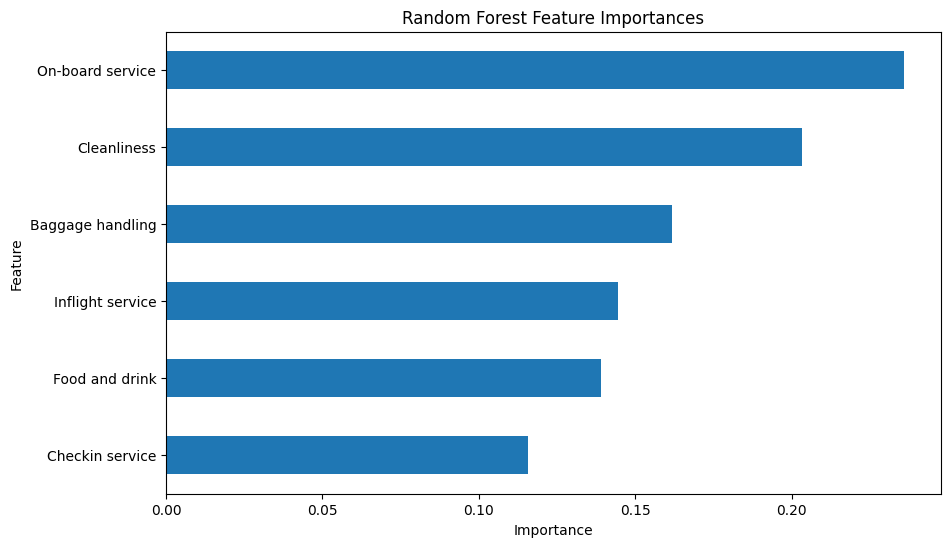

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_

# Create a Series for better visualization and sorting
features_df = pd.Series(feature_importances, index=X_train.columns)

# Sort the features by importance in descending order
sorted_features = features_df.sort_values(ascending=False)

print("Feature Importances for Random Forest Model:\n")
print(sorted_features)

# Optionally, visualize the feature importances
plt.figure(figsize=(10, 6))
sorted_features.plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Invert y-axis to have most important at the top
plt.show()

Significant Coefficients for Logistic Regression Model (sorted by absolute value):

                  Coefficient        P-value
Food and drink       0.066904   3.184844e-17
Inflight service     0.086712   2.431473e-21
Baggage handling     0.132833   1.194488e-50
Checkin service      0.235181  1.486713e-275
On-board service     0.395035   0.000000e+00
Cleanliness          0.417686   0.000000e+00


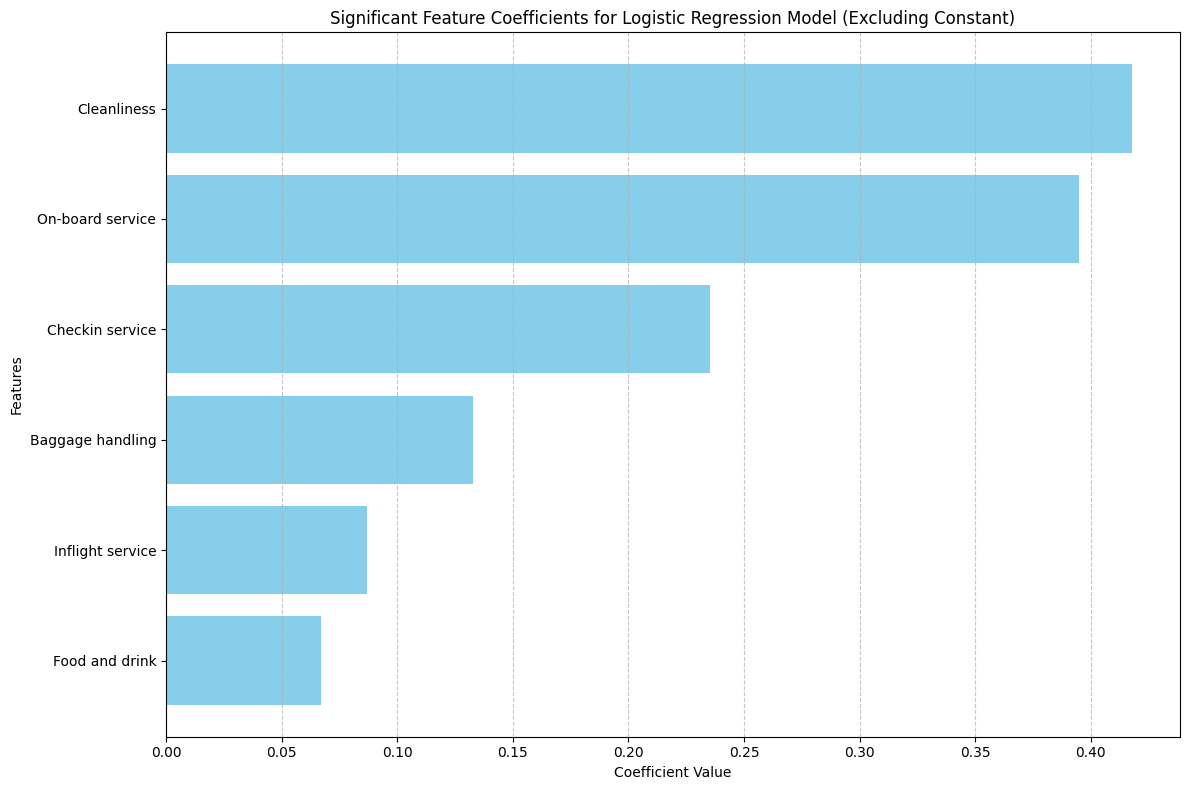

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get coefficients and p-values from the logistic regression model
coefficients = logit_results.params
p_values = logit_results.pvalues

# Filter for statistically significant variables (p-value < 0.05)
significant_coeffs = coefficients[p_values < 0.05]
significant_p_values = p_values[p_values < 0.05]

# Exclude 'const' from the significant variables for plotting
significant_coeffs = significant_coeffs.drop('const', errors='ignore')
significant_p_values = significant_p_values.drop('const', errors='ignore')

# Combine coefficients and p-values into a DataFrame for easier handling
coeff_df = pd.DataFrame({
    'Coefficient': significant_coeffs,
    'P-value': significant_p_values
})

# Sort by absolute coefficient value for importance visualization
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
sorted_coeffs = coeff_df.sort_values(by='Abs_Coefficient', ascending=True)

print("Significant Coefficients for Logistic Regression Model (sorted by absolute value):\n")
print(sorted_coeffs[['Coefficient', 'P-value']])

# Plot the coefficients
plt.figure(figsize=(12, 8))
plt.barh(sorted_coeffs.index, sorted_coeffs['Coefficient'], color=np.where(sorted_coeffs['Coefficient'] > 0, 'skyblue', 'salmon'))
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Significant Feature Coefficients for Logistic Regression Model (Excluding Constant)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

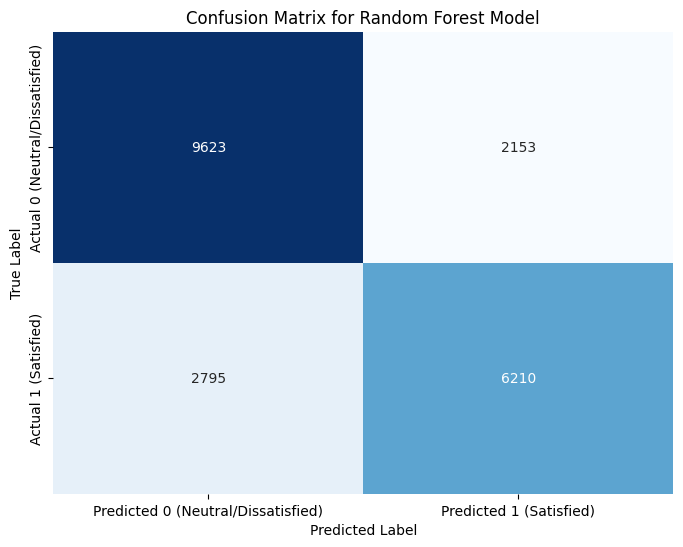

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for the Random Forest model
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (Neutral/Dissatisfied)', 'Predicted 1 (Satisfied)'],
            yticklabels=['Actual 0 (Neutral/Dissatisfied)', 'Actual 1 (Satisfied)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## Implement Random Forest Classifier

To potentially improve model performance and address underfitting, we will now implement a Random Forest Classifier. This ensemble method is known for its ability to handle complex relationships in data and often yields higher accuracy than simpler models like logistic regression.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Initialize the Random Forest Classifier
# Using a reasonable number of estimators and a random state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_rf = rf_model.predict(X_train)
y_train_prob_rf = rf_model.predict_proba(X_train)[:, 1]

# Make predictions on the test set
y_test_pred_rf = rf_model.predict(X_test)
y_test_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Training Set Performance
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_roc_auc_rf = roc_auc_score(y_train, y_train_prob_rf)

print(f"Random Forest - Training Accuracy: {train_accuracy_rf:.3f}")
print(f"Random Forest - Training ROC-AUC: {train_roc_auc_rf:.3f}")

print("\n--- Random Forest - Test Set Evaluation ---")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred_rf):.3f}")

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred_rf))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rf, digits=3))

print(f"ROC-AUC Score (Test Set): {roc_auc_score(y_test, y_test_prob_rf):.3f}")


Random Forest - Training Accuracy: 0.785
Random Forest - Training ROC-AUC: 0.869

--- Random Forest - Test Set Evaluation ---
Accuracy on test set: 0.762

Confusion Matrix (Test Set):
[[9623 2153]
 [2795 6210]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.775     0.817     0.795     11776
           1      0.743     0.690     0.715      9005

    accuracy                          0.762     20781
   macro avg      0.759     0.753     0.755     20781
weighted avg      0.761     0.762     0.761     20781

ROC-AUC Score (Test Set): 0.835


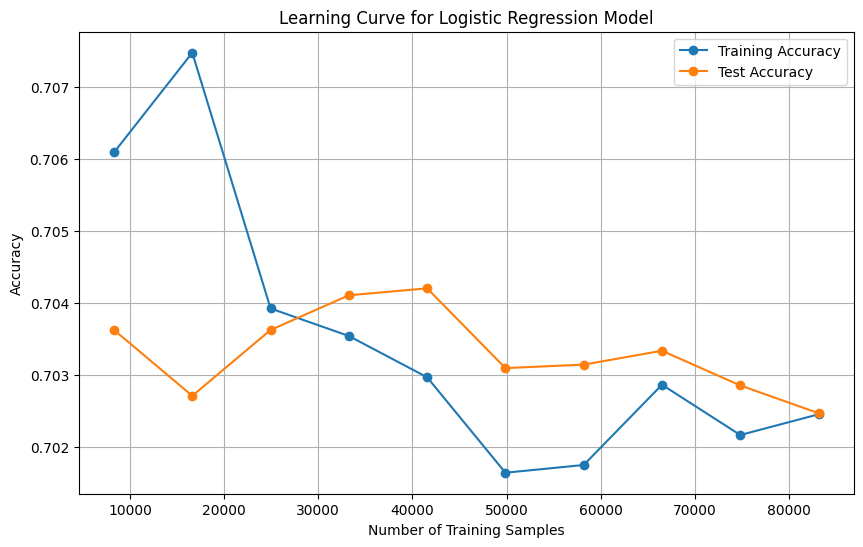

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

train_sizes = np.linspace(0.1, 1.0, 10)

train_accuracies = []
test_accuracies = []

for size in train_sizes:
    # Determine the number of samples for the current subset
    num_samples = int(size * len(X_train))

    # Select a subset of the training data
    X_train_subset = X_train.iloc[:num_samples]
    y_train_subset = y_train.iloc[:num_samples]

    # Add a constant to the subset of training data
    X_train_subset_const = sm.add_constant(X_train_subset)

    # Fit a new logistic regression model on the subset
    # Handle cases where the subset might be too small or cause issues
    try:
        logit_model_subset = sm.Logit(y_train_subset, X_train_subset_const)
        logit_results_subset = logit_model_subset.fit(disp=0) # disp=0 to suppress convergence messages

        # Calculate training accuracy for the subset
        y_train_pred_prob_subset = logit_results_subset.predict(X_train_subset_const)
        y_train_pred_subset = (y_train_pred_prob_subset >= 0.5).astype(int)
        train_accuracy_subset = accuracy_score(y_train_subset, y_train_pred_subset)
        train_accuracies.append(train_accuracy_subset)

        # Calculate test accuracy using the model trained on the subset
        y_test_pred_prob_subset = logit_results_subset.predict(X_test_const)
        y_test_pred_subset = (y_test_pred_prob_subset >= 0.5).astype(int)
        test_accuracy_subset = accuracy_score(y_test, y_test_pred_subset)
        test_accuracies.append(test_accuracy_subset)

    except Exception as e:
        print(f"Error fitting model with {num_samples} samples: {e}")
        train_accuracies.append(np.nan) # Append NaN if fitting fails
        test_accuracies.append(np.nan)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes * len(X_train), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(train_sizes * len(X_train), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression Model')
plt.legend()
plt.grid(True)
plt.show()

accuracy on training set and also accuracy on test set

show learning curve

plan to improve the model

show the code and what features used to encode

potential overfitting by showing training and test sets


# Task
Generate a learning curve for the logistic regression model by iteratively training it on increasing subsets of the training data (from 10% to 100% in 10% increments) and evaluating its accuracy on both the training and test sets. Finally, plot the learning curve to visualize the model's performance as the training data size increases.

## GenerateLearningCurve

### Subtask:
Generate a learning curve by iteratively training the logistic regression model on increasing subsets of the training data and evaluating its performance on both the training and test sets.


## Summary:

### Data Analysis Key Findings
*   The model's performance (accuracy) was assessed by iteratively training a logistic regression model on increasing subsets of the training data (from 10% to 100% in 10% increments).
*   Learning curves were generated to visualize the accuracy on both the training and test sets as the training data size increased.
*   The comparison of training and test accuracy curves provides insights into whether the model is underfitting (high bias), overfitting (high variance), or performing optimally.

### Insights or Next Steps
*   Analyze the generated learning curve to determine if the model suffers from high bias (underfitting) or high variance (overfitting), which would be indicated by the convergence behavior and the gap between the training and test accuracy curves.
*   Based on the learning curve analysis, decide on appropriate next steps, such as collecting more data (if the curves are still diverging and test accuracy is improving), simplifying the model (if overfitting), or increasing model complexity (if underfitting).


# Comparing Accuracy, precision and recall of logistic regression and random forest models


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

# ---- Logistic Regression Metrics ----
log_acc = accuracy_score(y_test, y_pred)
log_precision = precision_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)

# ---- Random Forest Metrics ----
rf_acc = accuracy_score(y_test, y_test_pred_rf)
rf_precision = precision_score(y_test, y_test_pred_rf)
rf_recall = recall_score(y_test, y_test_pred_rf)

# ---- Combine into a dataframe for clean comparison ----
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [log_acc, rf_acc],
    'Precision': [log_precision, rf_precision],
    'Recall': [log_recall, rf_recall]
})

print(results_df)


                 Model  Accuracy  Precision    Recall
0  Logistic Regression  0.702469   0.666627  0.626874
1        Random Forest  0.761898   0.742556  0.689617


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

# ----- Logistic Regression: train + test predictions -----
# Train
y_train_prob_log = logit_results.predict(X_train_const)
y_train_pred_log = (y_train_prob_log >= 0.5).astype(int)

# Test
y_test_prob_log = logit_results.predict(X_test_const)
y_test_pred_log = (y_test_prob_log >= 0.5).astype(int)


In [ ]:
results = []

# Logistic Regression - Train
results.append({
    'Model': 'Logistic Regression',
    'Data Split': 'Train',
    'Accuracy': accuracy_score(y_train, y_train_pred_log),
    'Precision': precision_score(y_train, y_train_pred_log),
    'Recall': recall_score(y_train, y_train_pred_log)
})

# Logistic Regression - Test
results.append({
    'Model': 'Logistic Regression',
    'Data Split': 'Test',
    'Accuracy': accuracy_score(y_test, y_test_pred_log),
    'Precision': precision_score(y_test, y_test_pred_log),
    'Recall': recall_score(y_test, y_test_pred_log)
})

# Random Forest - Train
results.append({
    'Model': 'Random Forest',
    'Data Split': 'Train',
    'Accuracy': accuracy_score(y_train, y_train_pred_rf),
    'Precision': precision_score(y_train, y_train_pred_rf),
    'Recall': recall_score(y_train, y_train_pred_rf)
})

# Random Forest - Test
results.append({
    'Model': 'Random Forest',
    'Data Split': 'Test',
    'Accuracy': accuracy_score(y_test, y_test_pred_rf),
    'Precision': precision_score(y_test, y_test_pred_rf),
    'Recall': recall_score(y_test, y_test_pred_rf)
})

results_df_full = pd.DataFrame(results)
print(results_df_full)


                 Model Data Split  Accuracy  Precision    Recall
0  Logistic Regression      Train  0.702453   0.666431  0.627374
1  Logistic Regression       Test  0.702469   0.666627  0.626874
2        Random Forest      Train  0.785450   0.772246  0.716074
3        Random Forest       Test  0.761898   0.742556  0.689617


# Task
Generate a learning curve for the Random Forest model by plotting the training and test accuracies against the number of training samples, and include a legend to distinguish between the two curves.

## Prepare for Learning Curve Generation

### Subtask:
Define the range for training data sizes and initialize lists to store training and test accuracies for the Random Forest model.


**Reasoning**:
Define the range for training data sizes, initialize lists for storing accuracies, and calculate the number of training samples for the Random Forest model's learning curve.



In [ ]:
import numpy as np

train_sizes = np.linspace(0.1, 1.0, 10)

train_accuracies_rf = []
test_accuracies_rf = []

# Calculate the actual number of training samples for each size
num_training_samples = (train_sizes * len(X_train))

print("Training data sizes (proportions):", train_sizes)
print("Number of training samples for each size:", num_training_samples)
print("Initialized empty lists for RF training and test accuracies.")

Training data sizes (proportions): [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Number of training samples for each size: [ 8312.3 16624.6 24936.9 33249.2 41561.5 49873.8 58186.1 66498.4 74810.7
 83123. ]
Initialized empty lists for RF training and test accuracies.


**Reasoning**:
To generate the learning curve, I will iterate through the defined training sizes, train a Random Forest model on each subset of the training data, and then calculate and store the training and test accuracies.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

for size in train_sizes:
    # Determine the number of samples for the current subset
    num_samples = int(size * len(X_train))

    # Select a subset of the training data
    X_train_subset = X_train.iloc[:num_samples]
    y_train_subset = y_train.iloc[:num_samples]

    # Initialize and train the Random Forest Classifier on the subset
    rf_model_subset = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model_subset.fit(X_train_subset, y_train_subset)

    # Calculate training accuracy for the subset
    y_train_pred_rf_subset = rf_model_subset.predict(X_train_subset)
    train_accuracy_rf_subset = accuracy_score(y_train_subset, y_train_pred_rf_subset)
    train_accuracies_rf.append(train_accuracy_rf_subset)

    # Calculate test accuracy using the model trained on the subset
    y_test_pred_rf_subset = rf_model_subset.predict(X_test)
    test_accuracy_rf_subset = accuracy_score(y_test, y_test_pred_rf_subset)
    test_accuracies_rf.append(test_accuracy_rf_subset)

print("Training accuracies for Random Forest:", train_accuracies_rf)
print("Test accuracies for Random Forest:", test_accuracies_rf)

Training accuracies for Random Forest: [0.8286814244465832, 0.8129812319538018, 0.8039781841514276, 0.7978585822129989, 0.7952407304925291, 0.792653339482285, 0.7900869624995703, 0.788023699960901, 0.7867932094639754, 0.785450477003958]
Test accuracies for Random Forest: [0.7444781290601992, 0.7531398873971417, 0.755642173138925, 0.7586256676772052, 0.7594918435108994, 0.7588662720754535, 0.7601174149463452, 0.7625715798084789, 0.7636783600404216, 0.7618978874933834]


**Reasoning**:
Now that the training and test accuracies for the Random Forest model have been calculated for various training data sizes, the next step is to plot these results to visualize the learning curve.



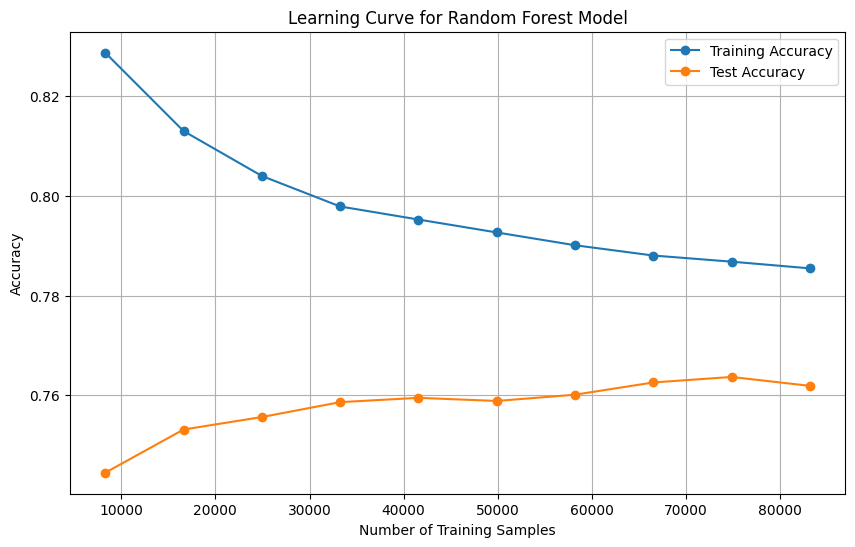

In [ ]:
import matplotlib.pyplot as plt

# Plot the learning curve for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(num_training_samples, train_accuracies_rf, label='Training Accuracy', marker='o')
plt.plot(num_training_samples, test_accuracies_rf, label='Test Accuracy', marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Random Forest Model')
plt.legend()
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings
*   As the number of training samples increased, the Random Forest model's training accuracy slightly decreased, from approximately 0.828 to 0.785.
*   Conversely, the test accuracy for the Random Forest model generally showed an upward trend with more training data, increasing from approximately 0.744 to 0.761.
*   The generated learning curve visually demonstrates the relationship between training and test accuracies and the number of training samples, indicating that the model's generalization performance improves with more data.

### Insights or Next Steps
*   The learning curve suggests that the Random Forest model benefits from more training data, as indicated by the improving test accuracy. Further performance gains might be possible with even larger datasets.
*   The persistent gap between training and test accuracy, even with more data, indicates that the model might still be overfitting to some extent. Future steps could involve hyperparameter tuning or exploring regularization techniques to reduce this gap and improve generalization.
